In [8]:
import warnings
warnings.filterwarnings("ignore")

import torch
from torch.utils.data import DataLoader, TensorDataset

from diffusers import DDPMScheduler
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler

from var_dgm import TimeGrad
from var_dgm.basic_models import HistoricalSimulation
import random
import os

In [ ]:
def seed_everything(seed: int):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.mps.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [2]:
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.set_context("paper")

Загружаем наши данные

In [3]:
df_my = pd.read_csv("saved_data.csv")
df_my.shape

(2854, 7)

In [4]:
df_my.columns

Index(['Date', 'LKOH', 'GAZP', 'SBER', 'TATN', 'NVTK', 'Index'], dtype='object')

In [5]:
if 'Date' in df_my.columns:
    df_my = df_my.set_index('Date')

log_returns = np.log(df_my / df_my.shift(1))
log_returns = log_returns.reset_index()
df_my = df_my.reset_index()

Разделим на обучающую и тестовую выборку, а также обучим модель

In [7]:
univariate_target = log_returns["Index"]

univariate_target = univariate_target.values[1:]
data_col = '2025-04-01'
train_size = log_returns[log_returns['Date'] <= data_col].index[-1] + 1
test_size = len(univariate_target) - train_size
train = univariate_target[:train_size]

ss = StandardScaler()
train_scaled = torch.tensor(ss.fit_transform(train.reshape(-1, 1)), dtype=torch.float32)

RANDOM_STATE = 12
seed_everything(RANDOM_STATE)
context_size = 90
num_train_samples = 2000
train_data = torch.zeros(num_train_samples, context_size, train_scaled.shape[1])
train_target = torch.zeros(num_train_samples, 1, train_scaled.shape[1])
train_idx = np.random.choice(np.arange(context_size, train_scaled.shape[0]), num_train_samples, replace=False)

for i in tqdm(range(num_train_samples)):
    idx = train_idx[i]
    train_context = train_scaled[idx-context_size:idx]
    target_obs = train_scaled[idx]
    train_data[i] = train_context
    train_target[i] = target_obs

# Create DataLoader for ease of torch training
train_loader = DataLoader(TensorDataset(train_data, train_target), batch_size=128, shuffle=False)


temp = torch.tensor(ss.transform(univariate_target.reshape(-1, 1)))
test_data_context = torch.zeros(test_size, context_size, temp.shape[1])
test_data_real = torch.zeros(test_size, 1, temp.shape[1])
for i in range(test_size):
    idx = i + train_size
    test_data_context[i] = temp[idx-context_size:idx]
    test_data_real[i] = temp[idx]

seed_everything(RANDOM_STATE)
sheduler = DDPMScheduler(num_train_timesteps=46, beta_end=0.35878774019831244, clip_sample=False)
model = TimeGrad(1, 1, hidden_size=50, num_layers=2, scheduler=sheduler, num_inference_steps=46)


optimizer = torch.optim.Adam(model.parameters(), lr=0.0008985916117829954)
device = "cuda:0"
n_epochs = 31
model.to(device)

model.fit(train_loader, optimizer, n_epochs, device)

  0%|          | 0/2000 [00:00<?, ?it/s]

Epochs:   0%|          | 0/31 [00:00<?, ?it/s]

[0.9082257263362408,
 0.8302159383893013,
 0.5575578324496746,
 0.3834812846034765,
 0.35938012786209583,
 0.337477533146739,
 0.3205801537260413,
 0.3322605397552252,
 0.3245652876794338,
 0.28253970853984356,
 0.2987202340736985,
 0.31749135069549084,
 0.2894032634794712,
 0.28439825773239136,
 0.30919184628874063,
 0.2874186038970947,
 0.2830580221489072,
 0.28116978984326124,
 0.28196917474269867,
 0.257494299672544,
 0.28555836249142885,
 0.2865475583821535,
 0.2739512035623193,
 0.2753413375467062,
 0.28335191030055285,
 0.2517912657931447,
 0.30411320365965366,
 0.2893793797120452,
 0.2569081671535969,
 0.2765646427869797,
 0.2851615836843848]

## Графики для одного дня прогноза

In [9]:
seed_everything(RANDOM_STATE)
alpha=0.01
n_samples=500
device="cuda:0" 
i = 0 
test_obs = test_data_context[[i]]

model.eval()
model.to(device)
batch = 500
arr = torch.zeros((n_samples // batch) * batch)

with torch.no_grad():
    for i in range(0, n_samples // batch):
        x = torch.cat([test_obs for _ in range(batch)])
        arr[i * batch : (i + 1) * batch] = (
            model.forward(x.to(device)).flatten().detach().cpu()
        )
arr = arr.reshape(-1, 1)
est = HistoricalSimulation(alpha=alpha)

VaR_5_TimeGrad, ES_5_TimeGrad = est.predict(arr)

In [10]:
VaR_5_TimeGrad = ss.inverse_transform([[VaR_5_TimeGrad]]).item()
ES_5_TimeGrad = ss.inverse_transform([[ES_5_TimeGrad]]).item()
real = ss.inverse_transform([[test_data_real[i].item()]]).item()

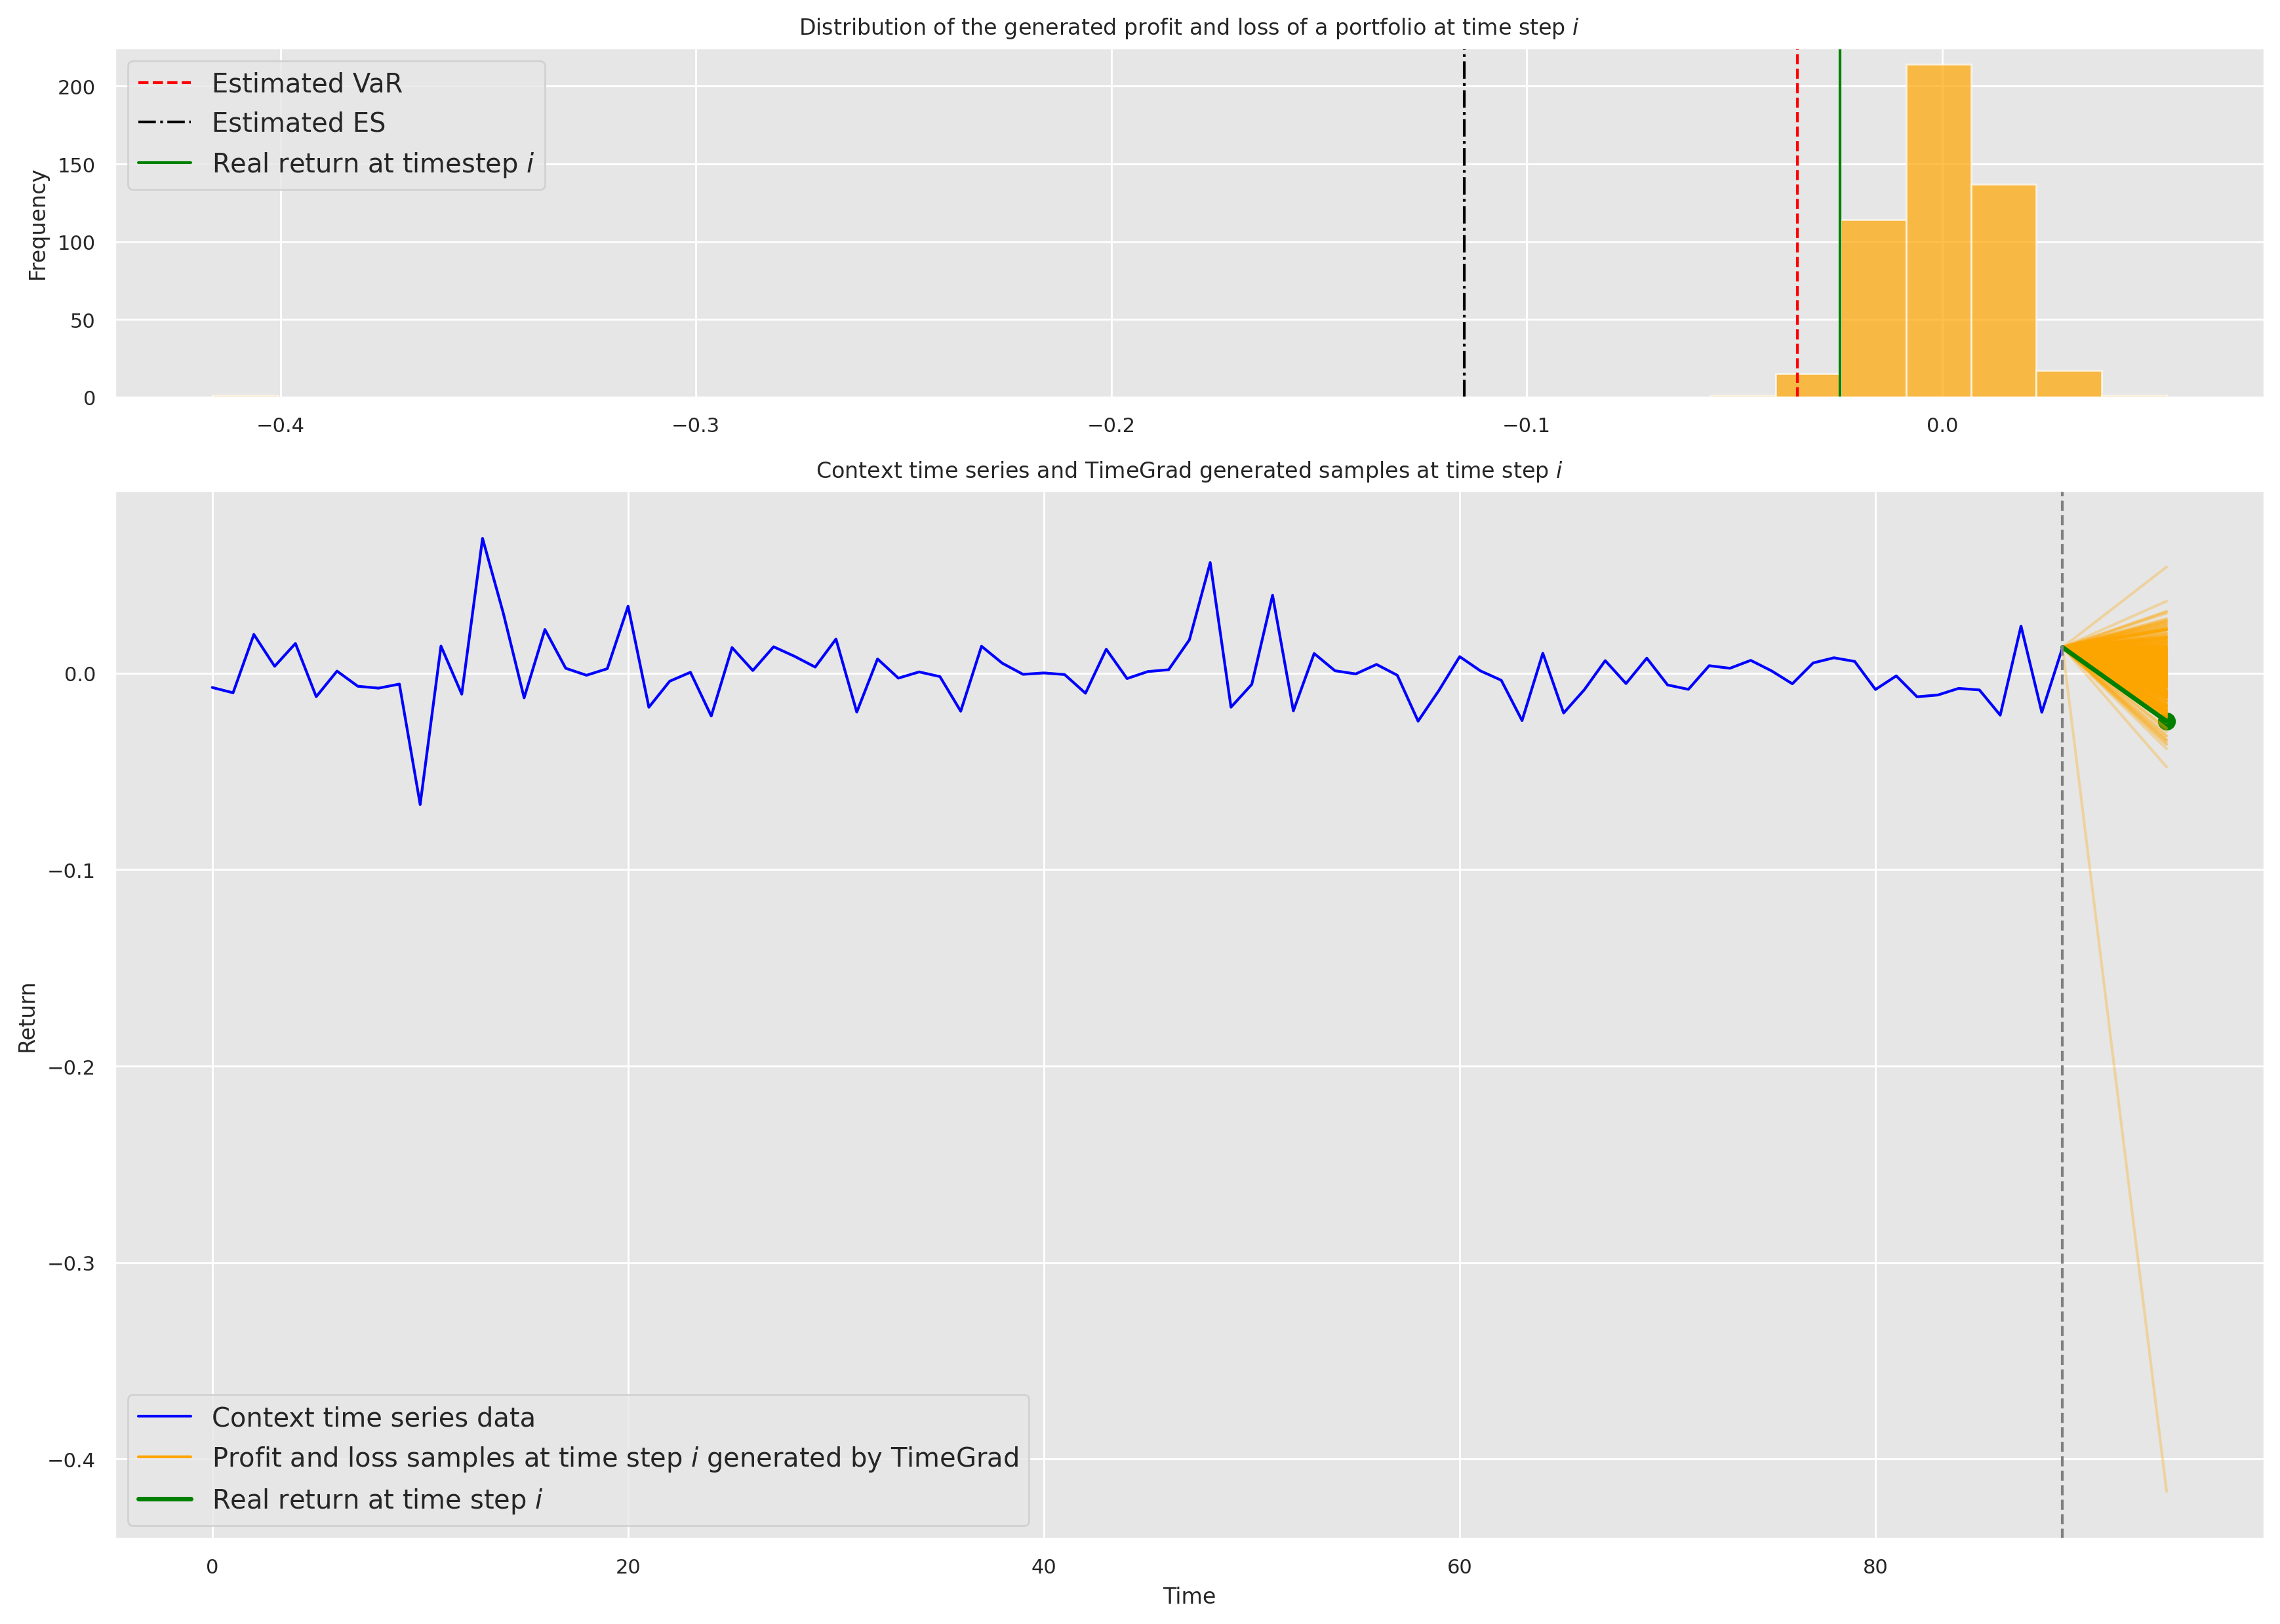

In [12]:
future_predictions = ss.inverse_transform(arr)
future_steps = 5
time_series = ss.inverse_transform(test_obs.reshape(-1, 1)).flatten()
n_points = time_series.shape[0]
n_future_paths = future_predictions.shape[0]

# Create a figure with two subplots (one for the histogram and one for the time series)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), gridspec_kw={'height_ratios': [1, 3]}, dpi=250)

# Plot the histogram of the first step of future predictions on the top subplot
future_first_step = future_predictions[:, 0]
ax1.hist(future_first_step, bins=30, color="orange", alpha=0.7)
ax1.axvline(VaR_5_TimeGrad, linestyle="--", label="Estimated VaR", color="red")
ax1.axvline(ES_5_TimeGrad, linestyle="-.", label="Estimated ES", color="black")
ax1.axvline(real, label="Real return at timestep $i$", color="green")
ax1.set_title('Distribution of the generated profit and loss of a portfolio at time step $i$')
ax1.set_ylabel('Frequency')
ax1.legend(fontsize='large')

# Plot the historical time series on the bottom subplot
ax2.plot(range(n_points), time_series, label='Context time series data', color='blue')

# Plot multiple one-step-ahead prediction paths on the bottom subplot
last_time_point = n_points - 1
for i in range(n_future_paths - 1):
    ax2.plot([last_time_point, last_time_point + future_steps], [time_series[-1], future_predictions[i, :].item()], color="orange", alpha=0.3)
ax2.plot([last_time_point, last_time_point + future_steps], [time_series[-1], future_predictions[-1, :].item()], color="orange", alpha=1, label="Profit and loss samples at time step $i$ generated by TimeGrad")


# Plot real obs
ax2.plot([last_time_point, last_time_point + future_steps], [time_series[-1], real], color="green", alpha=1, linewidth=2, label="Real return at time step $i$")
ax2.scatter(last_time_point + future_steps, real, color="green", s=50)

# Mark the last observation in the time series on the bottom subplot
ax2.axvline(x=last_time_point, color='grey', linestyle='--')
# ax2.scatter(last_time_point, time_series[-1], color='red')  # Mark the final point

# Adding labels and title to the bottom subplot
ax2.set_xlabel('Time')
ax2.set_ylabel('Return')
ax2.set_title("Context time series and TimeGrad generated samples at time step $i$")
ax2.legend(fontsize='large')
plt.tight_layout()
plt.show()


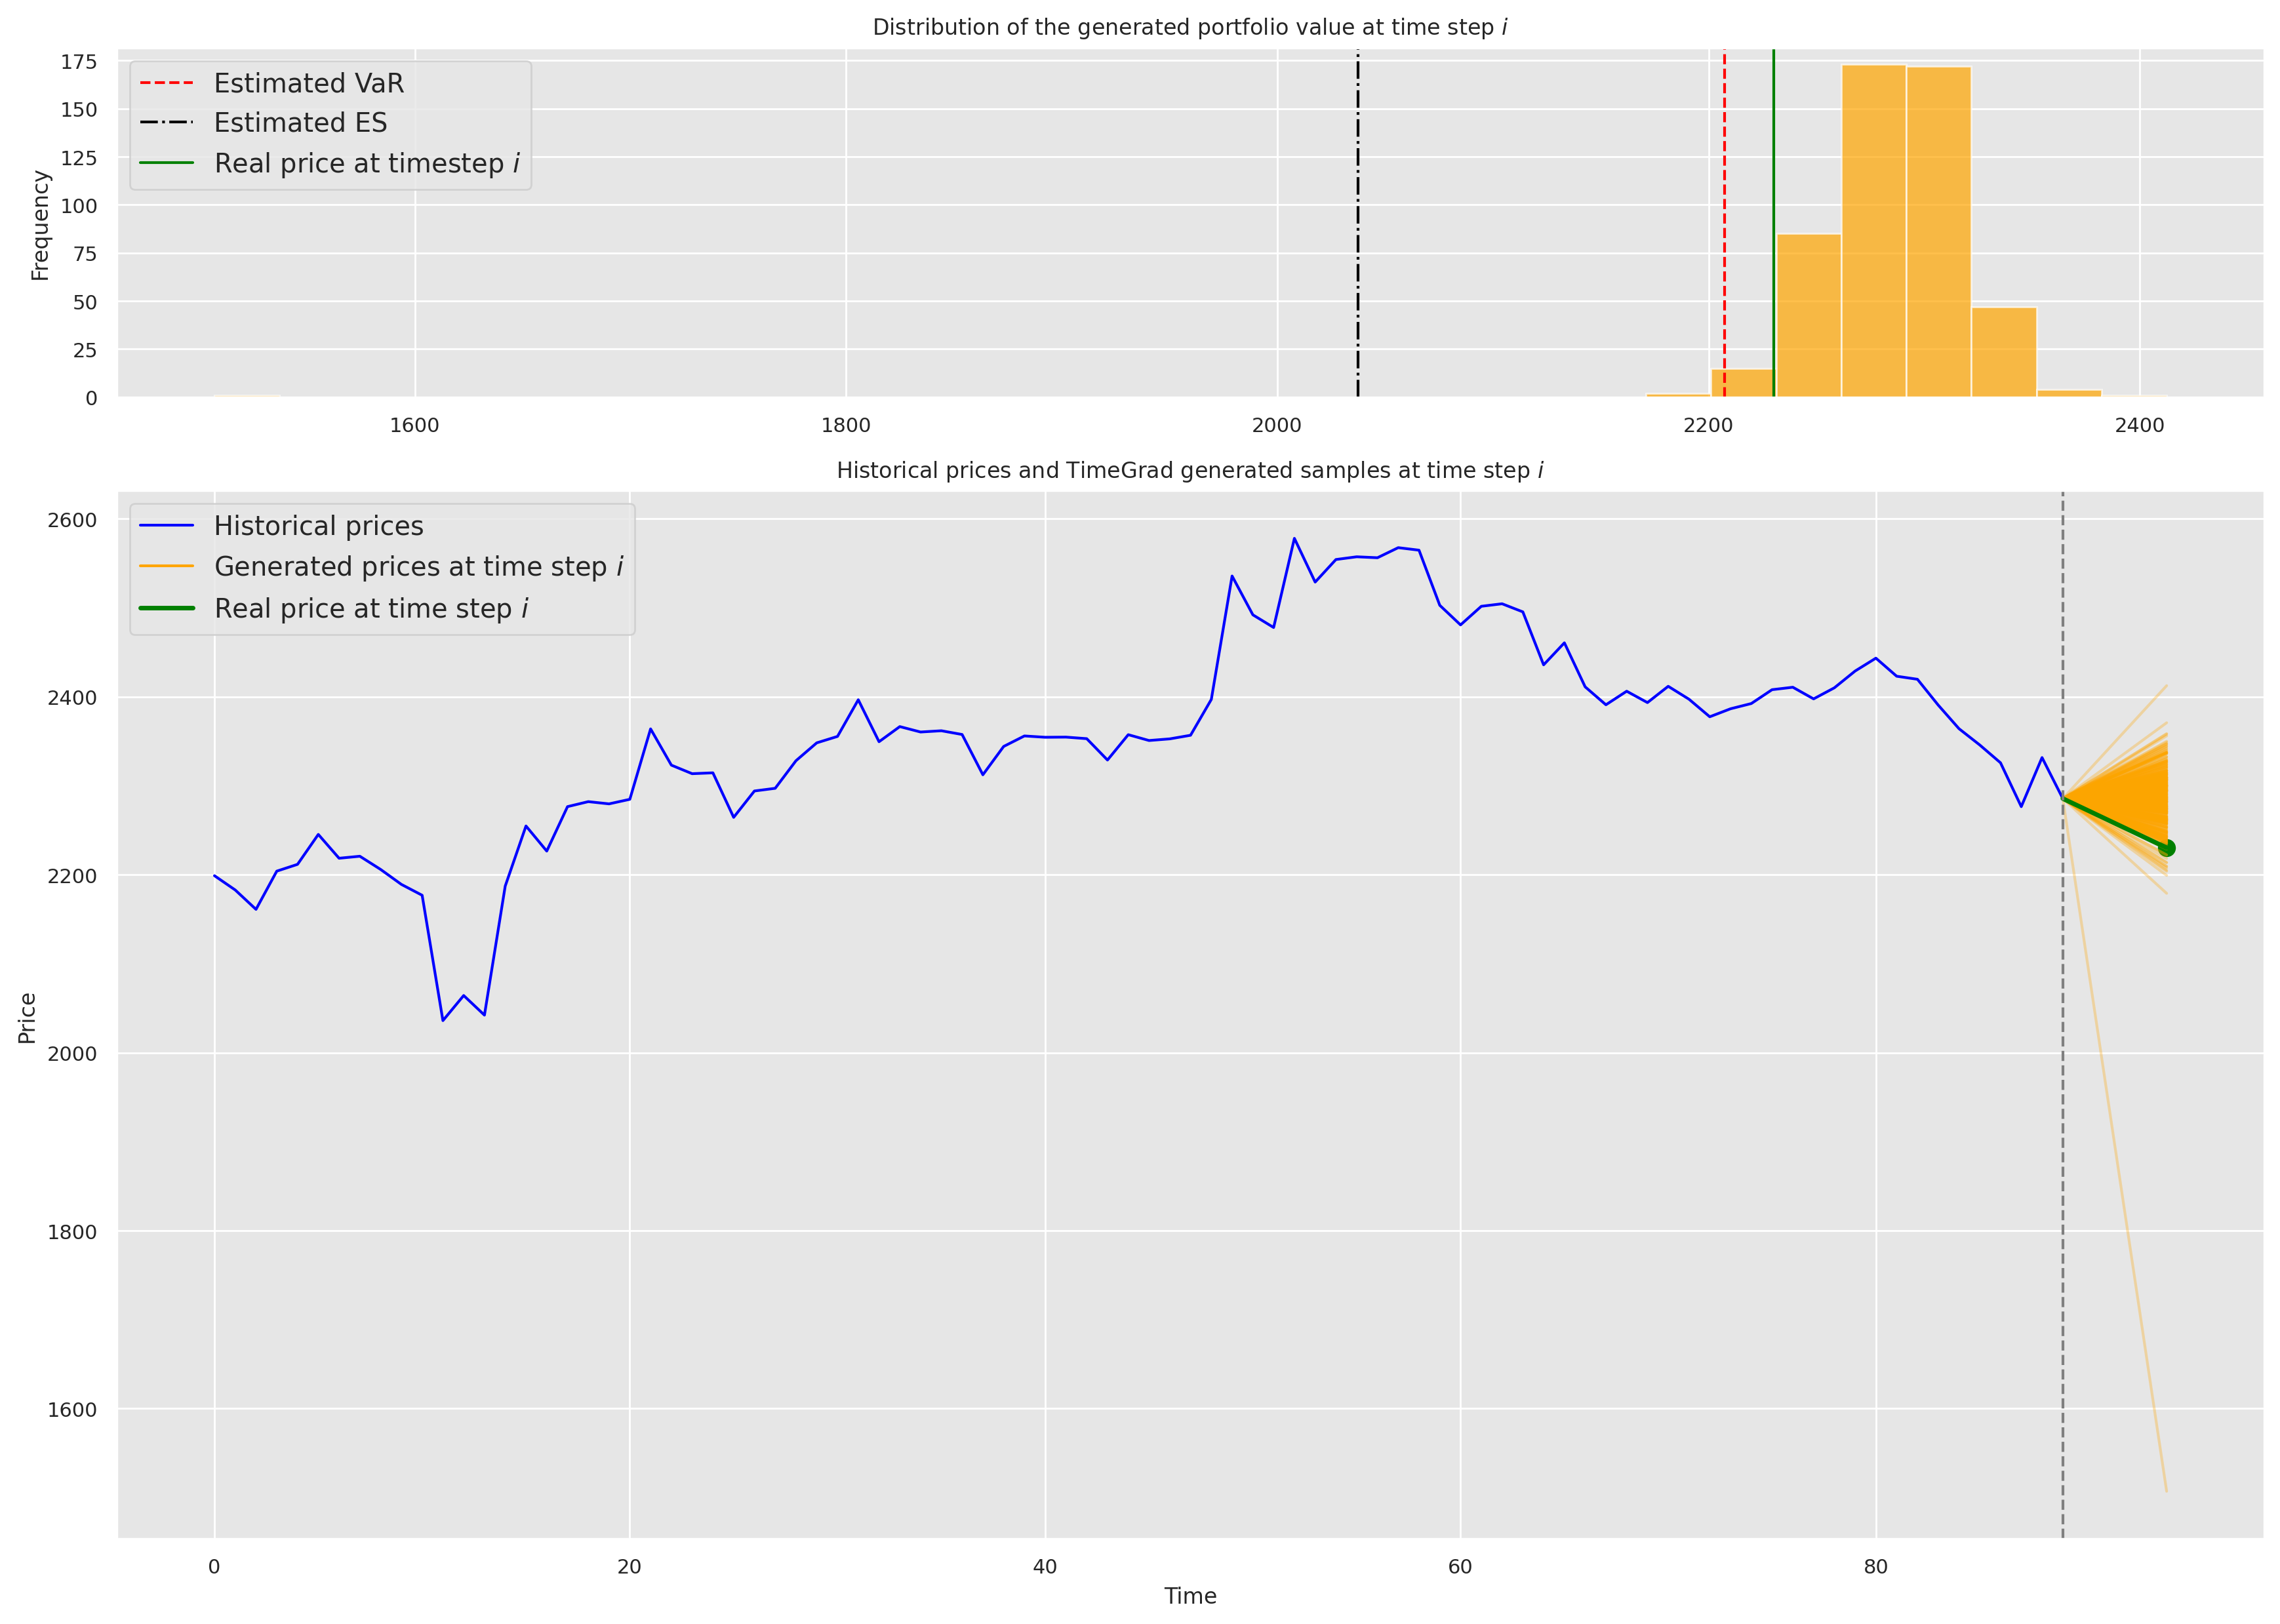

In [13]:
# # Восстанавливаем цены из логарифмических доходностей
def log_returns_to_prices(initial_price, log_returns):
    prices = [initial_price]
    for r in log_returns:
        prices.append(prices[-1] * np.exp(r))
    return np.array(prices)

initial_price_train = df_my["Index"].iloc[0]  # Начальная цена для train

initial_price_test = df_my[df_my['Date'] <= data_col]["Index"].iloc[-1]

# Восстанавливаем предсказанные доходности в цены
future_predictions_prices = initial_price_test * np.exp(future_predictions)
VaR_5_TimeGrad_price = initial_price_test * np.exp(VaR_5_TimeGrad)
ES_5_TimeGrad_price = initial_price_test * np.exp(ES_5_TimeGrad)
real_price = initial_price_test * np.exp(real)

# Модифицируем графики:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), gridspec_kw={'height_ratios': [1, 3]}, dpi=250)

# Гистограмма в ценах
ax1.hist(future_predictions_prices[:, 0], bins=30, color="orange", alpha=0.7)
ax1.axvline(VaR_5_TimeGrad_price, linestyle="--", label="Estimated VaR", color="red")
ax1.axvline(ES_5_TimeGrad_price, linestyle="-.", label="Estimated ES", color="black")
ax1.axvline(real_price, label="Real price at timestep $i$", color="green")
ax1.set_title('Distribution of the generated portfolio value at time step $i$')
ax1.set_ylabel('Frequency')
ax1.legend(fontsize='large')

# Временной ряд в ценах
time_series_prices = df_my[df_my['Date'] <= data_col]["Index"][-90:].values #log_returns_to_prices(initial_price_train, ss.inverse_transform(test_obs.reshape(-1, 1)).flatten())
ax2.plot(range(len(time_series_prices)), time_series_prices, label='Historical prices', color='blue')

# Предсказанные траектории в ценах
last_time_point = len(time_series_prices) - 1
for i in range(n_future_paths - 1):
    ax2.plot(
        [last_time_point, last_time_point + future_steps],
        [time_series_prices[-1], future_predictions_prices[i, 0]],
        color="orange", alpha=0.3
    )
ax2.plot(
    [last_time_point, last_time_point + future_steps],
    [time_series_prices[-1], future_predictions_prices[-1, 0]],
    color="orange", alpha=1, label="Generated prices at time step $i$"
)

# Реальная цена
ax2.plot(
    [last_time_point, last_time_point + future_steps],
    [time_series_prices[-1], real_price],
    color="green", alpha=1, linewidth=2, label="Real price at time step $i$"
)
ax2.scatter(last_time_point + future_steps, real_price, color="green", s=50)

ax2.axvline(x=last_time_point, color='grey', linestyle='--')
ax2.set_xlabel('Time')
ax2.set_ylabel('Price')
ax2.set_title("Historical prices and TimeGrad generated samples at time step $i$")
ax2.legend(fontsize='large')

plt.tight_layout()
plt.show()

# Базовый сценарий

In [14]:
n_samples = 10_000
horizon = 10
n_assets = test_data_context.shape[-1]  # Количество акций

model.eval()
with torch.no_grad():
    # Initialize with repeated context
    x = torch.cat([test_data_context[[0]] for _ in range(n_samples)]).to(device)  # [n_samples, context_len, n_assets]
    future_paths = torch.zeros((horizon, n_samples, n_assets)).to(device)
    
    for step in tqdm(range(horizon), desc="Генерация траекторий", unit="sample"):
        # Predict next step
        pred = model(x)  # [n_samples, 1, n_assets]
        future_paths[step] = pred.squeeze(1)  # [n_samples, n_assets]
        
        # Update context window
        pred = pred.view(n_samples, 1, n_assets)  # Ensure correct shape
        x = torch.cat([x[:, 1:, :], pred], dim=1)  # [n_samples, context_len, n_assets]

# Convert to numpy if needed
future_paths = future_paths.cpu().numpy()

Генерация траекторий:   0%|          | 0/10 [00:00<?, ?sample/s]

In [15]:
future_paths_copy = future_paths.copy()
for day in range(horizon):
    future_paths_copy[day, :, :] = ss.inverse_transform(
         future_paths_copy[day, : ,:]
    )
portfolio_day_np = np.squeeze(future_paths_copy, axis=-1) 

In [16]:
np.save("basic_index_sum.npy", portfolio_day_np)

# 1 Стресс-сценарий

In [17]:
df_my_last_train = df_my[df_my['Date'] <= data_col]['Index'][-91:]

In [18]:
stress_down = 0.9
# Создаём копию, чтобы не изменять оригинал
test_stress_data = df_my_last_train.copy()

# Уменьшаем последнее значение на 10% относительно предыдущего (второго с конца)
test_stress_data.iloc[-1] = test_stress_data.iloc[-2] * stress_down
test_stress_data_log = np.log(test_stress_data / test_stress_data.shift(1)).dropna()
# Преобразование и перевод в тензор
test_data_context_stress = torch.tensor(
    ss.transform(test_stress_data_log.to_numpy().reshape(-1, 1)),
    dtype=torch.float32
).unsqueeze(0)

In [19]:
n_samples = 10_000
horizon = 10
n_assets = test_data_context_stress.shape[-1]  # Количество акций

model.eval()
with torch.no_grad():
    # Initialize with repeated context
    x = torch.cat([test_data_context_stress for _ in range(n_samples)]).to(device)  # [n_samples, context_len, n_assets]
    future_paths_stress = torch.zeros((horizon, n_samples, n_assets)).to(device)
    
    for step in tqdm(range(horizon), desc="Генерация траекторий", unit="sample"):
        # Predict next step
        pred = model(x)  # [n_samples, 1, n_assets]
        future_paths_stress[step] = pred.squeeze(1)  # [n_samples, n_assets]
        
        # Update context window
        pred = pred.view(n_samples, 1, n_assets)  # Ensure correct shape
        x = torch.cat([x[:, 1:, :], pred], dim=1)  # [n_samples, context_len, n_assets]

# Convert to numpy if needed
future_paths_stress = future_paths_stress.cpu().numpy()

Генерация траекторий:   0%|          | 0/10 [00:00<?, ?sample/s]

In [20]:
future_paths_copy_stress = future_paths_stress.copy()
for day in range(horizon):
    future_paths_copy_stress[day, :, :] = ss.inverse_transform(
         future_paths_copy_stress[day, : ,:]
    )
portfolio_day_np_stress = np.squeeze(future_paths_copy_stress, axis=-1) 

In [21]:
np.save("stress_1_index_sum.npy", portfolio_day_np_stress)

In [22]:
portfolio_day_np_stress.shape

(10, 10000)

In [23]:
import numpy as np

# Ваши сгенерированные лог-доходности (10 дней, 100 сценариев, 1 актив)
log_returns = portfolio_day_np_stress.copy()  # shape: (10, 100)

# Пороги изменения за день
min_allowed = -0.3
max_allowed = 0.3

# Маска: True — если хотя бы в один день доходность выходит за допустимые пределы
bad_scenarios_mask = np.any((log_returns < min_allowed) | (log_returns > max_allowed), axis=0)

# Оставляем только "хорошие" сценарии
filtered_returns = log_returns[:, ~bad_scenarios_mask]  # shape: (10, n_good_scenarios)

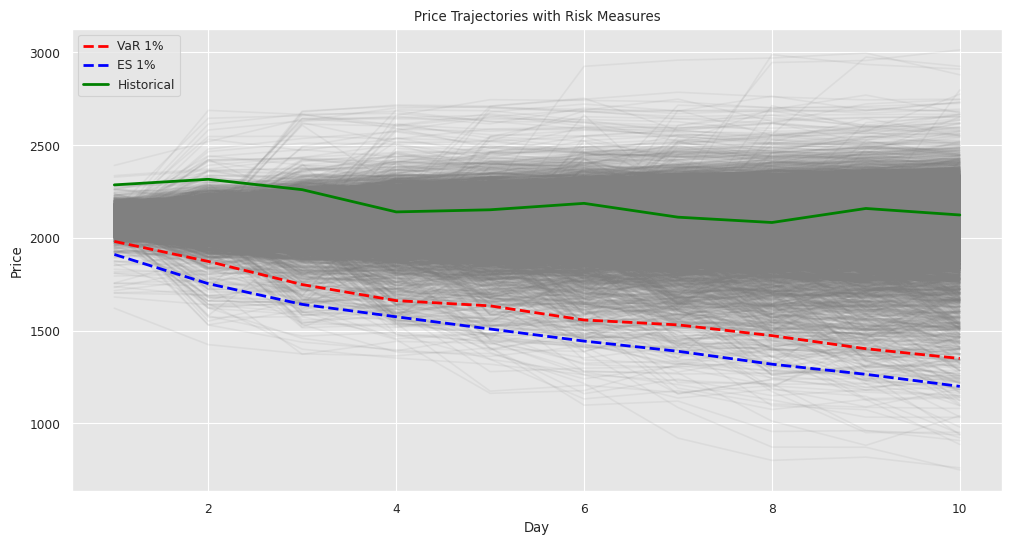

   Day  VaR_5%_price  ES_5%_price
0    1   1980.698375  1910.354736
1    2   1872.773837  1752.744263
2    3   1747.936292  1641.218872
3    4   1661.494174  1574.368042
4    5   1633.271083  1508.386597
5    6   1556.954537  1443.268433
6    7   1530.681179  1388.250854
7    8   1472.598284  1318.675537
8    9   1401.995492  1264.012817
9   10   1349.479113  1199.102783


In [27]:
# Ваши данные
horizon = 10  # дней
n_samples = 100  # сценариев
alpha = 0.01  # уровень значимости 5%

# 1. Преобразование лог-доходностей в цены (как у вас уже есть)
returns = np.exp(filtered_returns) - 1
cumulative_factors = np.cumprod(1 + returns, axis=0)
initial_price_test =  test_stress_data.iloc[-1] 
prices = initial_price_test * cumulative_factors

# 2. Расчет VaR и ES для цен (не для доходностей)
daily_VaR_price = []
daily_ES_price = []

for day in range(horizon):
    # Все возможные цены в этот день по всем сценариям
    day_prices = prices[day, :]
    
    # VaR (5%-й квантиль распределения цен)
    VaR_price = np.percentile(day_prices, alpha * 100)
    
    # ES (среднее значений ниже VaR)
    ES_price = day_prices[day_prices <= VaR_price].mean()
    
    daily_VaR_price.append(VaR_price)
    daily_ES_price.append(ES_price)

# 3. Создаем DataFrame для удобства
risk_df = pd.DataFrame({
    'Day': range(1, horizon+1),
    'VaR_5%_price': daily_VaR_price,
    'ES_5%_price': daily_ES_price
})

# 4. Визуализация
plt.figure(figsize=(12, 6))

# Все траектории
for i in range(prices.shape[1]):
    plt.plot(range(1, horizon+1), prices[:, i], color='gray', alpha=0.1)

# VaR и ES
plt.plot(risk_df['Day'], risk_df['VaR_5%_price'], 'r--', linewidth=2, label=f'VaR {alpha*100:.0f}%')
plt.plot(risk_df['Day'], risk_df['ES_5%_price'], 'b--', linewidth=2, label=f'ES {alpha*100:.0f}%')

# Исторические данные (если есть)
if 'df_my' in locals():
    historical = df_my[df_my['Date'] >= data_col]["Index"][:horizon].values
    plt.plot(range(1, horizon+1), historical, 'g-', linewidth=2, label='Historical')

plt.title('Price Trajectories with Risk Measures')
plt.xlabel('Day')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# Вывод таблицы с рисками
print(risk_df)

# 2 стресс-сценарий

In [28]:
df_my_last_train = df_my[df_my['Date'] <= data_col]['Index'][-91:]

In [29]:
def apply_volatility_stress(prices, n_days_stress=5, stress_factor=1.2):
    log_returns = np.log(prices / prices.shift(1)).dropna()
    log_returns_stressed = log_returns.copy()
    plt.plot(log_returns_stressed)
    log_returns_stressed[-n_days_stress:] *= stress_factor
    plt.plot(log_returns_stressed)

    test_data_context_stress = torch.tensor(
    ss.transform(log_returns_stressed.to_numpy().reshape(-1, 1)),
    dtype=torch.float32
    ).unsqueeze(0)

    return log_returns_stressed, test_data_context_stress

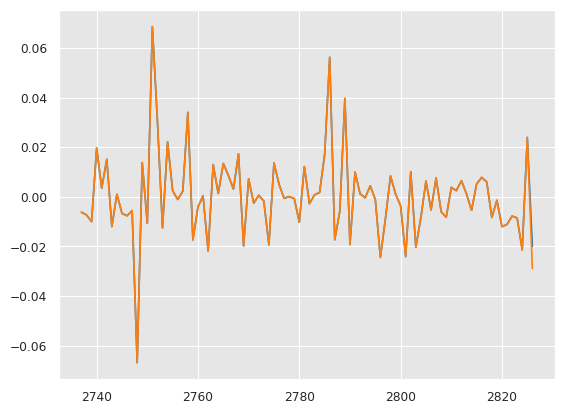

In [30]:
log_returns_stressed, test_data_context_volat = apply_volatility_stress(df_my_last_train, n_days_stress=1, stress_factor=1.45)

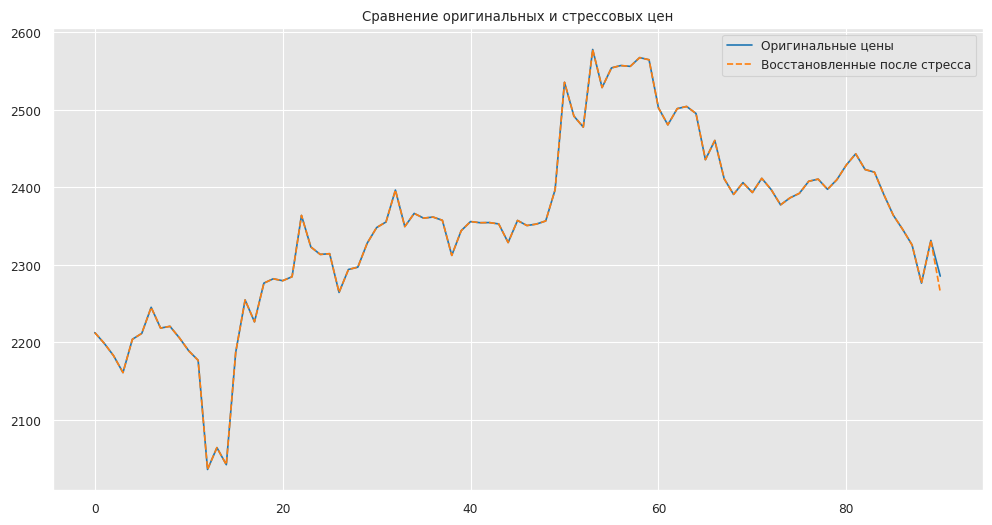

In [31]:
# Исходная цена (начальная точка)
first_price = df_my_last_train[-91:].iloc[0]

# Восстановление цен из логдоходностей
prices_recovered = first_price * np.exp(log_returns_stressed.cumsum())

# Добавляем первую точку, чтобы совпадало по длине с исходными данными
prices_recovered = pd.Series(
    np.concatenate(([first_price], prices_recovered)),
    index=df_my_last_train.index,
    name='Stressed_Price'
)

plt.figure(figsize=(12, 6))
plt.plot(df_my_last_train[-91:].values, label='Оригинальные цены')
plt.plot(prices_recovered.values, label='Восстановленные после стресса', linestyle='--')
plt.legend()
plt.title('Сравнение оригинальных и стрессовых цен')
plt.show()

In [32]:
n_samples = 10_000
horizon = 10
n_assets = test_data_context_volat.shape[-1]  # Количество акций

model.eval()
with torch.no_grad():
    # Initialize with repeated context
    x = torch.cat([test_data_context_volat for _ in range(n_samples)]).to(device)  # [n_samples, context_len, n_assets]
    future_paths_volt = torch.zeros((horizon, n_samples, n_assets)).to(device)
    
    for step in tqdm(range(horizon), desc="Генерация траекторий", unit="sample"):
        # Predict next step
        pred = model(x)  # [n_samples, 1, n_assets]
        future_paths_volt[step] = pred.squeeze(1)  # [n_samples, n_assets]
        
        # Update context window
        pred = pred.view(n_samples, 1, n_assets)  # Ensure correct shape
        x = torch.cat([x[:, 1:, :], pred], dim=1)  # [n_samples, context_len, n_assets]

# Convert to numpy if needed
future_paths_volt = future_paths_volt.cpu().numpy()

Генерация траекторий:   0%|          | 0/10 [00:00<?, ?sample/s]

In [33]:
future_paths_copy_volt = future_paths_volt.copy()
for day in range(horizon):
    future_paths_copy_volt[day, :, :] = ss.inverse_transform(
         future_paths_copy_volt[day, : ,:]
    )
portfolio_day_np_volt = np.squeeze(future_paths_copy_volt, axis=-1) 

In [34]:
np.save("stress_2_index_sum.npy", portfolio_day_np_volt)

# 3 стресс-сценарий

In [35]:
# Загрузка данных из .npy файла
synthetic_prices_basic  = np.load('basic_index_sum.npy')

# Проверка данных
print("Тип данных:", type(synthetic_prices_basic))  # <class 'numpy.ndarray'>
print("Форма массива:", synthetic_prices_basic.shape)  # (размерность, например, (forecast_horizon, n_simulations))

transposed_prices_basic = synthetic_prices_basic.T
print("Форма массива:", transposed_prices_basic.shape)  # (размерность, например, (n_simulations, forecast_horizon))

Тип данных: <class 'numpy.ndarray'>
Форма массива: (10, 10000)
Форма массива: (10000, 10)


In [36]:
log_returns = transposed_prices_basic.copy()  # shape: (n_simulations, forecast_horizon)

# Максимально допустимое падение/рост за день

# Пороги изменения за день
min_allowed = -0.25
max_allowed = 0.25

# Маска: True — если хотя бы в один день доходность выходит за допустимые пределы
bad_scenarios_mask = np.any((log_returns < min_allowed) | (log_returns > max_allowed), axis=1)

# Оставляем только "хорошие" сценарии
filtered_returns = log_returns[~bad_scenarios_mask, :]
print(filtered_returns.shape)

(9935, 10)


In [40]:
from scipy.stats import t
# Для одномерного случая (1 актив) предполагаем w = 1
mu = np.array([filtered_returns[:, 1].mean()])  # Средняя доходность
sigma = np.std(filtered_returns[:, 1])          # Стандартное отклонение

df_t = 3  # Степени свободы t-распределения
p = 0.99
k_t = t.ppf(p, df_t)  # Квантиль t-распределения

# Расчет VaR (в терминах доходности)
r_star = mu - k_t * sigma  # Одномерный аналог Sigma_w/denominator = sigma
worst_loss = -r_star       # Поскольку w=1
worst_loss

array([0.06488122], dtype=float32)

In [41]:
stress_down = 1-worst_loss
# Создаём копию, чтобы не изменять оригинал
test_stress_data = df_my_last_train.copy()

# Уменьшаем последнее значение на 10% относительно предыдущего (второго с конца)
test_stress_data.iloc[-1] = test_stress_data.iloc[-2] * stress_down
test_stress_data_log = np.log(test_stress_data / test_stress_data.shift(1)).dropna()
# Преобразование и перевод в тензор
test_data_context_stress = torch.tensor(
    ss.transform(test_stress_data_log.to_numpy().reshape(-1, 1)),
    dtype=torch.float32
).unsqueeze(0)

In [43]:
n_samples = 10_000
horizon = 10
n_assets = test_data_context_stress.shape[-1]  # Количество акций

model.eval()
with torch.no_grad():
    # Initialize with repeated context
    x = torch.cat([test_data_context_stress for _ in range(n_samples)]).to(device)  # [n_samples, context_len, n_assets]
    future_paths_stress = torch.zeros((horizon, n_samples, n_assets)).to(device)
    
    for step in tqdm(range(horizon), desc="Генерация траекторий", unit="sample"):
        # Predict next step
        pred = model(x)  # [n_samples, 1, n_assets]
        future_paths_stress[step] = pred.squeeze(1)  # [n_samples, n_assets]
        
        # Update context window
        pred = pred.view(n_samples, 1, n_assets)  # Ensure correct shape
        x = torch.cat([x[:, 1:, :], pred], dim=1)  # [n_samples, context_len, n_assets]

# Convert to numpy if needed
future_paths_stress = future_paths_stress.cpu().numpy()

Генерация траекторий:   0%|          | 0/10 [00:00<?, ?sample/s]

In [44]:
future_paths_copy_stress = future_paths_stress.copy()
for day in range(horizon):
    future_paths_copy_stress[day, :, :] = ss.inverse_transform(
         future_paths_copy_stress[day, : ,:]
    )
portfolio_day_np_stress = np.squeeze(future_paths_copy_stress, axis=-1) 

In [45]:
np.save("stress_3_index_sum.npy", portfolio_day_np_stress)